# Statistiques descriptives 

# Modules utiles

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import seaborn as sns
import sklearn.preprocessing 
from sklearn.preprocessing import scale 


c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Données ENEDIS

"Ce jeu de données restitue la consommation d’électricité au pas 1/2h des points de soutirage <= 36kVA raccordés au réseau Enedis. Il donne les volumes d'énergie soutirés, les courbes de charge moyennes de clients dotés de compteurs communicants et le nombre de clients. Ces agrégats sont disponibles par plage de puissance souscrite, profil et région."

Dictionnaire des variables : https://data.enedis.fr/api/datasets/1.0/conso-inf36-region/attachments/note_externe_jdd_article_23_pdf/

In [ ]:
#chemin elena
enedis = pd.read_csv("C:/Users/elelo/Documents/ENSAE/données statapp/Données/conso-inf36-region.csv",sep=";")

#chemin jérémie
#enedis = pd.read_csv("/Users/jeremiedarracq/Stat-app/enedis.csv",sep=";")

#chemin côme
#enedis = pd.read_csv("/Users/",sep=";")


In [ ]:
enedis_2020=pd.read_csv("Données/enedis_2020.csv")
enedis_2021=pd.read_csv("Données/enedis_2021.csv")

enedis=pd.concat([enedis_2020,enedis_2021])
enedis.drop_duplicates(inplace=True)
enedis.sort_values("horodate",inplace=True)

In [136]:
enedis_final=pd.read_csv("Données/enedis_final.csv")

On enlève les profils pro :


In [ ]:
enedis["profil_type"]=enedis["profil"].apply(lambda x : x[0:3])
enedis

In [ ]:
enedis.drop(enedis[enedis["profil_type"]!="RES"].index,inplace=True)

On récupère la date :

In [ ]:
## On extrait la date pour classifier par jour 
enedis["date"]=enedis["horodate"].apply(lambda x : x[0:10])
enedis

On ajoute la consommation moyenne par 1/2h prar profil et par plage de puissance : $\frac{total\_energie\_soutiree}{nb\_points\_soutirage}$ :

In [ ]:
enedis["energie_soutiree_moyenne"]=enedis["total_energie_soutiree_wh"]/enedis["nb_points_soutirage"]

In [134]:
enedis_final["energie_soutiree_moyenne"]=enedis_final["energie_soutiree_moyenne"]*(10**6)

## Données méteo


**Données des températures régionales du 1er janvier 2018 au 31 octobre 2022 :**

In [ ]:
meteo_reg_df=pd.read_csv("Données/temperature-quotidienne-regionale.csv",";")
meteo_reg_df


In [ ]:
meteo_reg_df.groupby(["region"])["tmoy"]

Boite à moustache des températures. Consommation moyenne quotidienne par région, chaque jour combien un foyer consomme

## Données socio économique

In [ ]:
socio=pd.read_csv("Données/data_socio.csv",sep=";",header=2)
socio

In [ ]:
socio["Code"]=socio["Code"].astype("str")
socio.drop( socio[ (socio['Code'] == "1") | (socio['Code'] == "2") | (socio['Code'] == "3") | (socio['Code'] == "4") | (socio['Code'] == "6")].index, inplace=True)
socio

## Base de données merged

In [ ]:
enedis["code_region"]=enedis["code_region"].astype("str")

In [ ]:
enedis_socio=pd.merge(enedis,socio,how='left',left_on="code_region",right_on="Code")

Finalement, il faut merger les données météo et enedis sur date et région

In [ ]:
meteo_reg_df["code_insee_region"]=meteo_reg_df["code_insee_region"].astype("str")

In [ ]:
enedis_final=pd.merge(enedis_socio,meteo_reg_df,how='left',left_on=["date","code_region"],right_on=["date","code_insee_region"])

In [ ]:
enedis_final.to_csv("Données/enedis_final.csv",index=False)

## Statistiques descriptives sur bdd enedis

In [ ]:
# Affiche les données où il y a des valeurs manquantes pour tmoy

bool_series = pd.isnull(enedis_final["tmoy"])
nul=enedis_final[bool_series]
nul
# il manque 10 903 lignes de températures, pour la journée du 2021-04-30


#### Statistiques sur les températures

* Variation de la température par jour par région 
  

In [ ]:
res=enedis_final[enedis_final["region_x"]=='Occitanie'].groupby("date")["tmoy"].mean()
plt.figure(figsize=(20, 8))
plt.plot(res)
t2=["2020-06-06","2020-08-06","2020-10-06","2020-12-06","2021-02-06","2021-04-06","2021-06-06"]
plt.xticks(t2,["juin 2020","aout 2020","octobre 2020","décembre 2020","février 2021","avril 2021","juin 2021"])
plt.xlabel('date')
plt.ylabel('temperature')
plt.title("Variation de la température par jour pour l'"+'Occitanie',size=18)
plt.show()

In [ ]:
def temp_day_region(df,region):
    res=enedis_final[enedis_final["region_x"]==region].groupby("date")["tmoy"].mean()
    plt.plot(res, label= region)
    t2=["2020-06-06","2020-08-06","2020-10-06","2020-12-06","2021-02-06","2021-04-06","2021-06-06"]
    plt.xticks(t2,["juin 2020","aout 2020","octobre 2020","décembre 2020","février 2021","avril 2021","juin 2021"])
    plt.xlabel('date')
    plt.ylabel('temperature')
    plt.title("Variation de la température par jour pour "+region,size=18)
    
    

In [ ]:
plt.figure(figsize=(20, 8))
temp_day_region(enedis_final,'Centre-Val de Loire')

In [ ]:
regions=list(enedis_final["region_x"].unique())

def temp_day_regions(df,regions):
    plt.figure(figsize=(20, 8))
    for region in regions:
        temp_day_region(enedis_final,region)
    t2=["2020-06-06","2020-08-06","2020-10-06","2020-12-06","2021-02-06","2021-04-06","2021-06-06"]
    plt.xticks(t2,["juin 2020","aout 2020","octobre 2020","décembre 2020","février 2021","avril 2021","juin 2021"])
    plt.xlabel('date')
    plt.ylabel('temperature')
    plt.legend()
    plt.title("Variation de la température par jour par région",size=18)
    plt.show()

temp_day_regions(enedis_final,regions)

* Corrélation entre Température moyenne et énergie moyenne soutirée par jour (A verifier)

On va créer deux df : un avec les profils hautes conso >6kva et les autres <6kva

In [6]:
haute_conso=enedis_final[enedis_final["profil"]=="RES11 (+ RES11WE)"]
basse_conso=enedis_final[enedis_final["profil"]=="RES1 (+ RES1WE)"]

In [ ]:
def corr_total_energie_temperature(df,region):
    plt.figure(figsize=(20, 8))
    plt.ylabel("total d'energie soutirée par jour")
    plt.xlabel('temperature')
    plt.legend()
    plt.title("Corrélation entre température moyenne et énergie moyenne soutirée par jour pour "+region,size=18)
    X1=df[df["region_x"]==region].groupby("date")["tmoy"].mean()
    X2=df[df["region_x"]==region].groupby("date")["energie_soutiree_moyenne"].mean()
    plt.plot(X1,X2,"ob")
    plt.show()
    correlation=X1.corr(X2)
    print("La corrélation est de " +str(correlation))
    

In [ ]:
corr_total_energie_temperature(haute_conso,"Occitanie")
corr_total_energie_temperature(haute_conso,"Hauts-de-France")

corr_total_energie_temperature(basse_conso,"Hauts-de-France")


In [ ]:
def conso_day_reg(df,region):
    res=df[df["region_x"]==region].groupby("date")["energie_soutiree_moyenne"].mean()
    plt.figure(figsize=(20, 8))
    plt.plot(res)
    t2=["2020-06-06","2020-08-06","2020-10-06","2020-12-06","2021-02-06","2021-04-06","2021-06-06"]
    plt.xticks(t2,["juin 2020","aout 2020","octobre 2020","décembre 2020","février 2021","avril 2021","juin 2021"])
    plt.xlabel('date')
    plt.ylabel('consommation moyenne en Wh par jour')
    plt.title("Variation de la consommation électrique sur 1 an pour l'"+region,size=18)
    plt.show
    

In [ ]:
conso_day_reg(haute_conso,'Occitanie')

conso_day_reg(haute_conso,'Hauts-de-France')

In [ ]:
plt.figure(figsize=(30, 10))
haute_conso.boxplot(by="region_x",column=["energie_soutiree_moyenne"],grid=False,figsize=(30, 15))
basse_conso.boxplot(by="region_x",column=["energie_soutiree_moyenne"],grid=False,figsize=(30, 15))

### Deux barplot : conso totale et population

<function matplotlib.pyplot.show(close=None, block=None)>

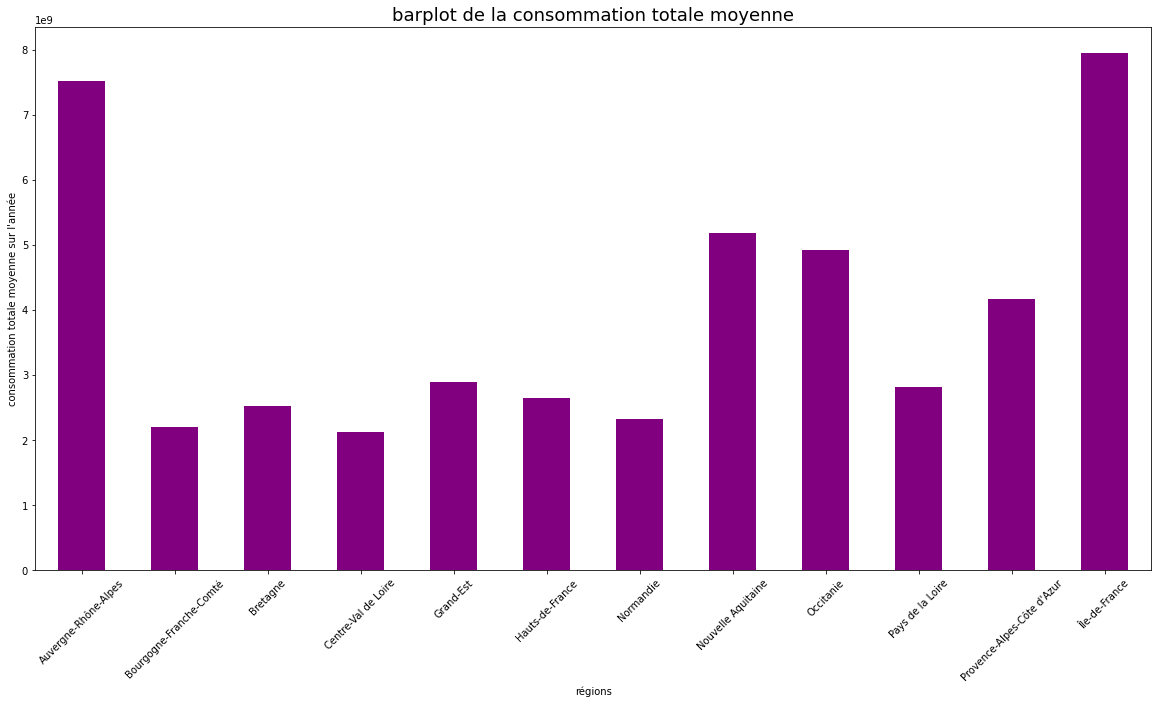

In [50]:
# Premièrement : conso totale pour chaque jour par région
# deuxièment : moyenne des conso totale sur l'année
# barplot des conso totale sur l'année


total_energie_temp=haute_conso.groupby(["region_x","date"])["total_energie_soutiree_wh"].sum().reset_index()
total_energie=total_energie_temp.groupby("region_x")["total_energie_soutiree_wh"].mean()

plt.figure(figsize=(20, 10))
total_energie.plot.bar(color="purple")
plt.xlabel('régions')
plt.xticks(rotation = 45)
plt.ylabel("consommation totale moyenne sur l'année")
plt.title("barplot de la consommation totale moyenne",size=18)
plt.show



In [51]:
population=socio.drop(socio[(socio["Libellé"]=="Corse")].index)
population=population.groupby("Libellé")["Population au dernier recensement 2018"].mean()
plt.figure(figsize=(20, 10))
population.plot.bar(color="blue")
plt.xlabel('régions')
plt.xticks(rotation = 45)
plt.ylabel("consommation totale moyenne sur l'année")
plt.title("Population au dernier recensement 2018 par région",size=18)
plt.show

NameError: name 'socio' is not defined

# Par saison : graphique des molaires 

### Données pour haute conso :

In [ ]:
haute_conso["mois"]=haute_conso["date"].apply(lambda x : x[5:7])

In [ ]:
ete=haute_conso[(haute_conso["mois"]=="06")|(haute_conso["mois"]=="07")|(haute_conso["mois"]=="08")]

automne=haute_conso[(haute_conso["mois"]=="09")|(haute_conso["mois"]=="10")|(haute_conso["mois"]=="11")]

hiver=haute_conso[(haute_conso["mois"]=="12")|(haute_conso["mois"]=="01")|(haute_conso["mois"]=="02")]

printemps=haute_conso[(haute_conso["mois"]=="03")|(haute_conso["mois"]=="04")|(haute_conso["mois"]=="05")]

### Données pour basse conso :

In [147]:
basse_conso["mois"]=basse_conso["date"].apply(lambda x : x[5:7])

C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/3728763804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basse_conso["mois"]=basse_conso["date"].apply(lambda x : x[5:7])


In [148]:
ete_basse=basse_conso[(basse_conso["mois"]=="06")|(basse_conso["mois"]=="07")|(basse_conso["mois"]=="08")]

automne_basse=basse_conso[(basse_conso["mois"]=="09")|(basse_conso["mois"]=="10")|(basse_conso["mois"]=="11")]

hiver_basse=basse_conso[(basse_conso["mois"]=="12")|(basse_conso["mois"]=="01")|(basse_conso["mois"]=="02")]

printemps_basse=basse_conso[(basse_conso["mois"]=="03")|(basse_conso["mois"]=="04")|(basse_conso["mois"]=="05")]

## Fonction pour tracer les molaires :

In [149]:
haute=[ete,automne,hiver,printemps]

In [151]:
# molaire conso moyenne par heure pour chaque jour de la saison
def molaire_saison(data_saison,region,saison):
    conso_saison_region=data_saison[data_saison["region_x"]==region]

    conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
    total_conso_saison_region=conso_saison_region.groupby("heure")["energie_soutiree_moyenne"].mean()

    
    plt.plot(total_conso_saison_region,label=saison)
    t2=["00:00","04:00","08:00","12:00","15:00","18:00","21:00","23:30"]
    plt.xticks(t2,["00:00","04:00","8:00","12:00","15:00","18:00","21:00","23:30"])
    plt.xlabel('Heure')
    plt.ylabel("Consommation d'énergie")
    plt.title('Molaire pour la saison '+saison+", région "+region,size=25)


haute=[ete,automne,hiver,printemps]
basse=[ete_basse,automne_basse,hiver_basse,printemps_basse]

def molaire_toute_saison(region):
    plt.figure(figsize=(20, 8))
    molaire_saison(ete_basse,region,"été")
    molaire_saison(automne_basse,region,"automne")
    molaire_saison(hiver_basse,region,"hiver")
    molaire_saison(printemps_basse,region,"printemps")
    t2=["00:00","04:00","08:00","12:00","15:00","18:00","21:00","23:30"]
    plt.xticks(t2,["00:00","04:00","8:00","12:00","15:00","18:00","21:00","23:30"])
    plt.xlabel('Heure')
    plt.ylabel("Consommation d'énergie")
    plt.legend()
    plt.title('Molaire par saison pour la région '+region,size=25)
   
    plt.show()
   

C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/32991595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  haute_conso_30_09_2020["heure"]=haute_conso_30_09_2020["horodate"].apply(lambda x : x[11:16])


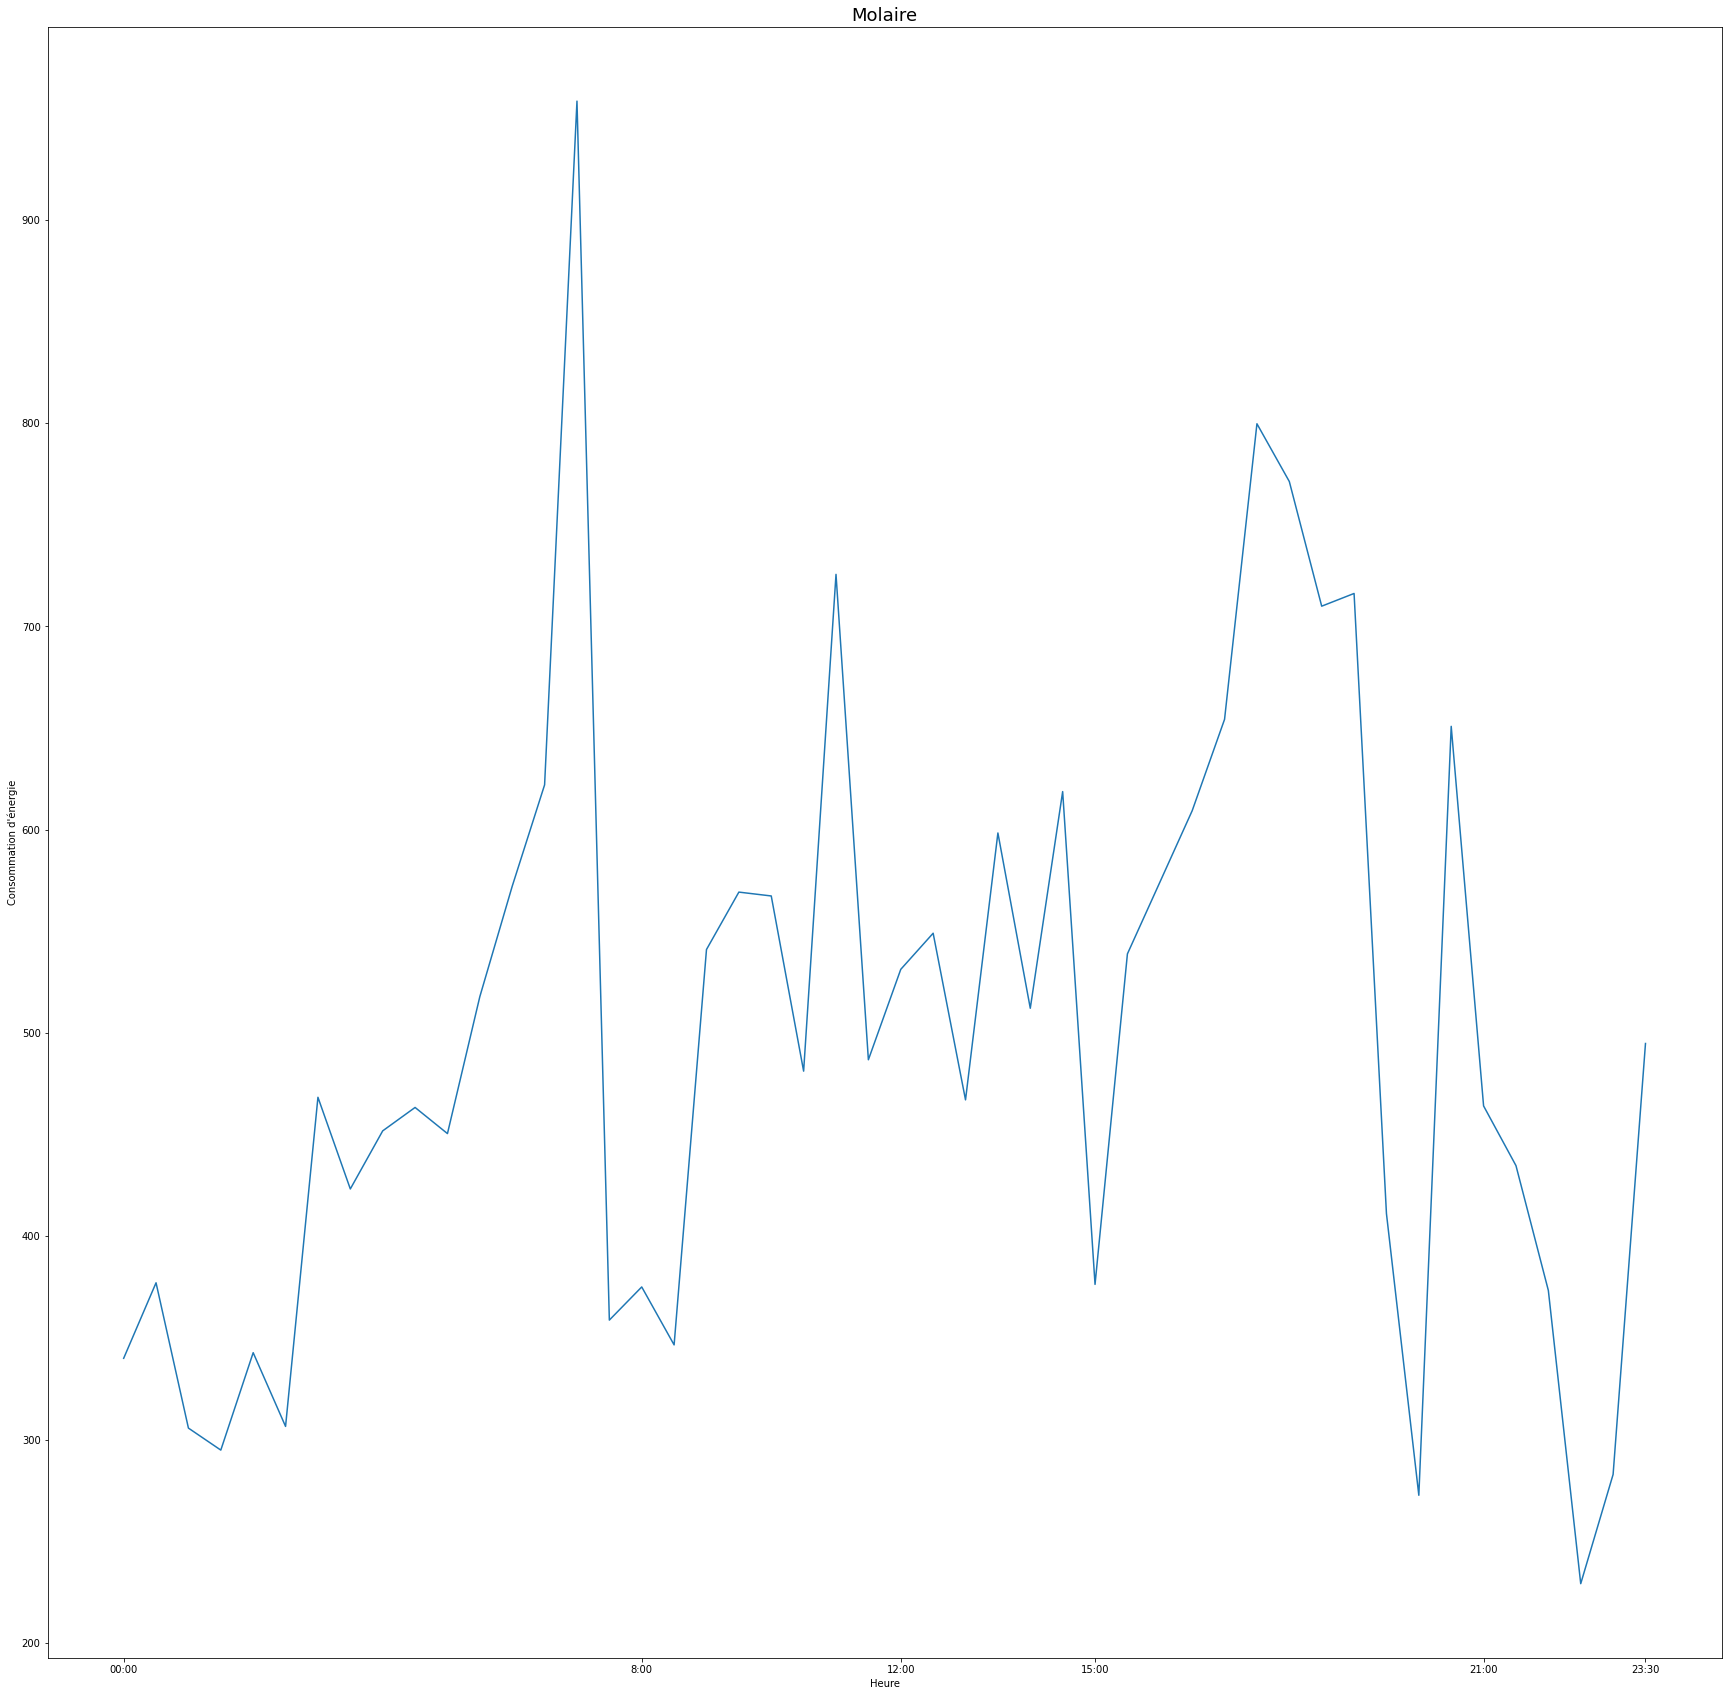

In [145]:
haute_conso_idf=haute_conso[haute_conso["region_x"]=="Île-de-France"]
haute_conso_30_09_2020 = haute_conso_idf[haute_conso_idf["date"]=="2020-09-30"]
haute_conso_30_09_2020["heure"]=haute_conso_30_09_2020["horodate"].apply(lambda x : x[11:16])
total_haute_conso_30_09_2020=haute_conso_30_09_2020.groupby("heure")["energie_soutiree_moyenne"].mean().reset_index()

plt.figure(figsize=( 30, 30))
plt.plot(total_haute_conso_30_09_2020["heure"],total_haute_conso_30_09_2020["energie_soutiree_moyenne"] )
t2=["00:00","08:00","12:00","15:00","21:00","23:30"]
plt.xticks(t2,["00:00","8:00","12:00","15:00","21:00","23:30"])
plt.xlabel('Heure')
plt.ylabel("Consommation d'énergie")
plt.title('Molaire',size=18)
plt.show()


C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying 

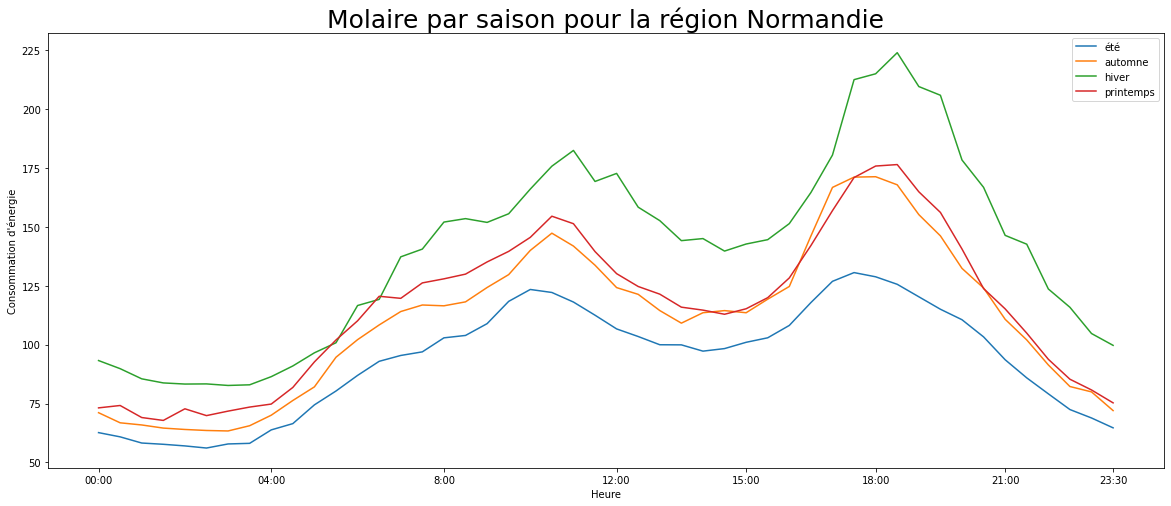

In [152]:
molaire_toute_saison("Normandie")

C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying 

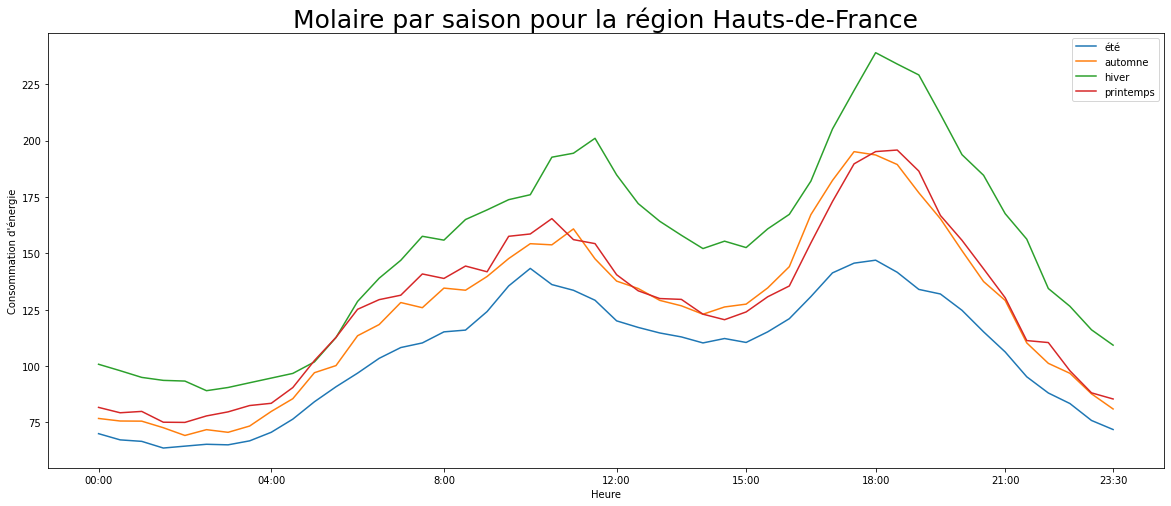

In [154]:
molaire_toute_saison("Hauts-de-France")

C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying 

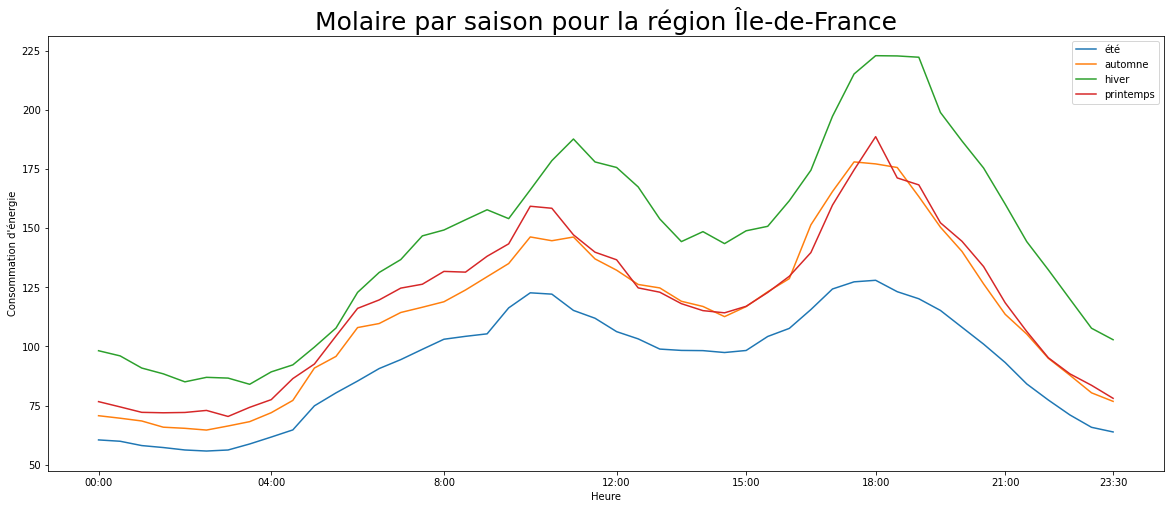

In [153]:
molaire_toute_saison("Île-de-France")

C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_14664/2593956589.py:5: SettingWithCopyWarning: 
A value is trying 

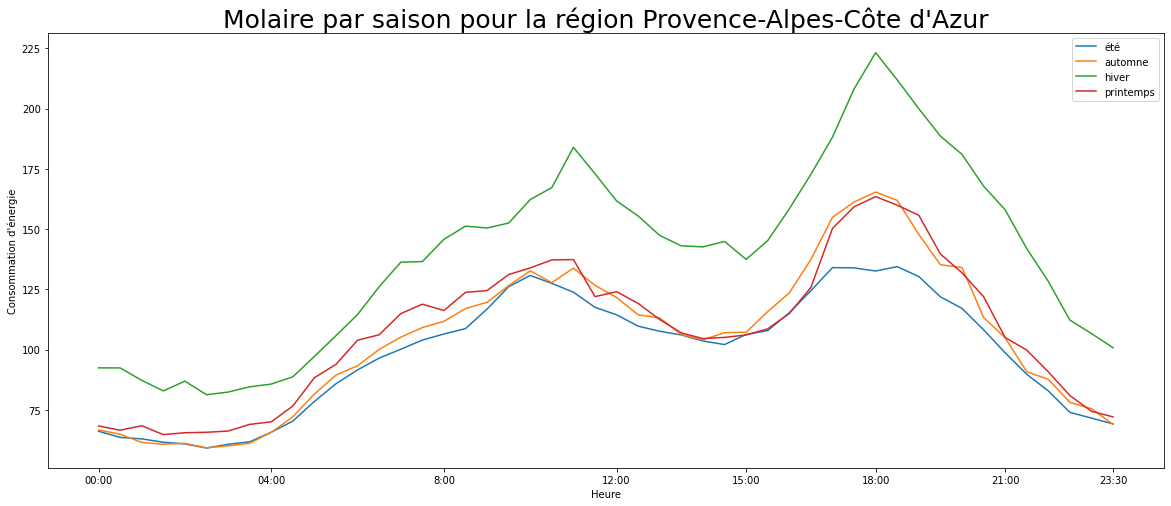

In [155]:
molaire_toute_saison("Provence-Alpes-Côte d'Azur")